In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

#from labellines import labelLine, labelLines
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [50]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

S_n = 7.246 #энергия отрыва нейтрона
S_2n = 17.02 #энергия отрыва двух нейтронов

#total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [7]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/Z_54.ocr.xls', 
                                    parse_cols="A,B", decimal='.')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
p       48 non-null float64
F0L0    48 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [8]:
Fermi_func_new_data.head()

,p,F0L0
0,0.1,68.550
1,0.2,34.627
2,0.3,23.465
3,0.4,17.995
4,0.5,14.807


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [9]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['p'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### LAMPF flux

In [10]:
Integral_value = 5e7

In [11]:
flux = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/nu_e_spectrum_LAMPF.csv', 
                   sep=';', decimal=',')

In [12]:
flux.head()

,x,y
0,0.060269,0.000967
1,0.186330,0.001236
2,0.455347,0.001576
3,0.724364,0.001910
4,0.993381,0.002359


In [13]:
trapz(flux['y'].values, flux['x'].values)

28.671121694890385

In [14]:
step_all_fluxes = 0.01 #MeV
Energy_all_fluxes = np.arange(0,60,step_all_fluxes)

In [15]:
normed_flux = flux['y'].values/trapz(flux['y'].values, flux['x'].values)*Integral_value
normed_flux = np.interp(x=Energy_all_fluxes, xp=flux['x'].values, 
                       fp=normed_flux)

In [16]:
#trapz(normed_flux, flux['x'].values)
trapz(normed_flux, Energy_all_fluxes)

50061068.262794286

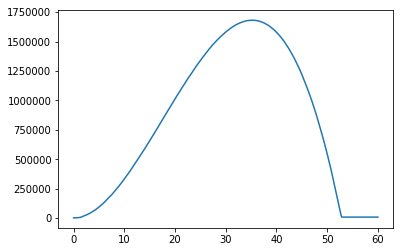

In [35]:
plt.plot(Energy_all_fluxes, normed_flux,)

In [37]:
normed_flux

array([1685.84081601, 1685.84081601, 1685.84081601, ..., 8527.00046608,
       8527.00046608, 8527.00046608])

### 8B flux from BS05OP

In [18]:
BS05OP_B = 5.69e6
b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')

b8_flux = np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * BS05OP_B ),

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [19]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [20]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [21]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, flux=normed_flux, energies_array=Energy_all_fluxes, step=step_all_fluxes):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate = sum(flux*sigma_total*step) * math.pow(10,36)
    return rate

In [22]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [23]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [24]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

## Матричные элементы от ЮС

In [45]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

41.485

In [46]:
def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Ex = np.arange(0,70,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [47]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

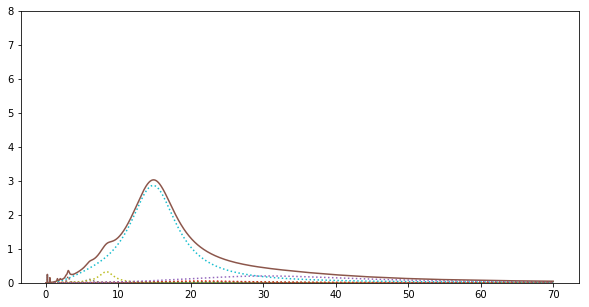

In [48]:
plt.figure(figsize=(10,5))
plt.ylim(0,8)
for elem in plots:
    plt.plot(Ex, elem, ls=':')
plt.plot(Ex, summ)
plt.show()

In [49]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [52]:
summ_Sn = border_func(Ex, summ, S_n)
summ_Sn_S2n = border_func2(Ex, summ, S_n, S_2n)

### total

In [53]:
p_list = np.arange(0,60, 0.1) #p = z - Q

sigma_matr_Sn_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_Sn, 200) for p in p_list]

sigma_matr_Sn_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_Sn_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_Sn_S2n_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_Sn_S2n, 200) for p in p_list]

sigma_matr_Sn_S2n_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_Sn_S2n_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [54]:

SNU_Sn = rate_calc(sigma_matr_Sn_full)
SNU_Sn_S2n = rate_calc(sigma_matr_Sn_S2n_full)

SNU_Sn, SNU_Sn_S2n

(6501.477610506726, 33878.92490160783)

In [55]:
#BS05OP
rate_calc(sigma_matr_Sn_full, flux=b8_flux)


14.4042670879836

### расчет числа атомов для эксперимента LAMPF

In [56]:
N_a = 6.02e23 #число Авагадро
mass = 1.5e6 #1.5 тонны в граммах
mu = 127 #молярная масса в г\моль

Num_at = mass/mu*N_a
Num_at

7.110236220472441e+27

In [57]:
t_month = 30*24*60*60 #число секунд в месяце
t_year = 365*24*60*60 #число секунд в году
t_month, t_year

(2592000, 31536000)

In [58]:
#Число атомов 126Хе

Num_at*(SNU_Sn_S2n)*10**(-36)*t_month

624.3795159882334